## Imports

In [1]:
!pip install datasets transformers
!apt install git-lfs
!pip install iso-639
!pip3 install nltk emoji==0.6.0
!pip install matplotlib
# !pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 10.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 t

In [2]:
# !pip install matplotlib --upgrade

In [3]:
import transformers
import pandas as pd
import json
import re
import numpy as np
from iso639 import languages
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import TweetTokenizer
from emoji import demojize
from datetime import datetime
from datasets import Dataset
from huggingface_hub import notebook_login
notebook_login()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploratory Data Analysis

####Load and pre-process dataset

In [5]:
path = "/content/drive/My Drive/tweets-dataset/"

In [6]:
tweets_list = pd.read_pickle(path+"tweets_500.pkl")
json.loads(json.dumps(tweets_list[10]))

{'created_at': 'Tue Oct 07 09:47:42 +0000 2014',
 'tweet_id': 519423814795415552,
 'text': "RT @karpathy: Conferences are where I go to sell work that I've done 1 year ago, barely remember, and have entirely deprecated with better …",
 'like_count': 0,
 'quote_count': 0,
 'reply_count': 0,
 'retweet_count': 9,
 'user': {'id': 589612103,
  'name': 'Sebastian Gerke',
  'screen_name': 'sebgerke',
  'location': 'Berlin, Germany',
  'followers_count': 38,
  'friends_count': 365,
  'created_at': 'Fri May 25 02:26:00 +0000 2012',
  'favourites_count': 55,
  'verified': False,
  'statuses_count': 14,
  'lang': None,
  'profile_image_url': 'http://pbs.twimg.com/profile_images/674338142946762756/hPS5u2XU_normal.jpg'},
 'place': None,
 'lang': 'en',
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'karpathy',
    'name': 'Andrej Karpathy',
    'id': 33836629,
    'id_str': '33836629',
    'indices': [3, 12]}],
  'urls': []},
 'possibly_sensitive': False,
 'is_quo

In [7]:
def getLanguageName(lang):
    try:
        return languages.get(alpha2=lang).name
    except:
        return lang

def get_user_mentions_list(entities):
  user_mentions = []
  if not (entities and 'user_mentions' in entities):
    return []
  for user_mention in entities['user_mentions']:
    user_mentions.append(user_mention['screen_name'])
  return user_mentions


def get_hashtags_list(entities):
  hashtags = []
  if not (entities and 'hashtags' in entities):
    return []
  for hashtag in entities['hashtags']:
    hashtags.append(hashtag['text'])
  return hashtags

def get_urls_list(entities):
  urls = []
  if not (entities and 'urls' in entities):
    return []
  for url in entities['urls']:
    urls.append(url['url'])
  return urls

In [8]:
df = pd.DataFrame(tweets_list)
df['created_at'] = df['created_at'].apply(lambda x : re.sub(r"\+.{4}\s", "", x))
df['created_at'] = df['created_at'].apply(lambda x : datetime.strptime(x, '%a %b %d %H:%M:%S %Y'))
df['year'] = df['created_at'].dt.year
df['month'] = df['created_at'].dt.month
df['day'] = df['created_at'].dt.day
df['weekday'] = df['created_at'].dt.weekday
df['hour'] = df['created_at'].dt.hour

df['tweet_id'] = df['tweet_id'].astype(str)
df['lang'] = df['lang'].apply(lambda x : getLanguageName(x))
df['log_like_count'] = df['like_count'].apply(lambda x : np.log10(x))

df['author_id'] = df['user'].apply(lambda x: x['screen_name']).astype(str)
df['author_loc'] = df['user'].apply(lambda x: x['location'])
df['followers_count'] = df['user'].apply(lambda x: x['followers_count'])
df['following_count'] = df['user'].apply(lambda x: x['friends_count'])
df['author_verified'] = df['user'].apply(lambda x: x['verified'])
df['total_tweets_by_author_count'] = df['user'].apply(lambda x: x['statuses_count'])
df['author_created_at'] = df['user'].apply(lambda x: x['created_at'])
df['author_created_at'] = df['author_created_at'].apply(lambda x : re.sub(r"\+.{4}\s", "", x))
df['author_created_at'] = df['author_created_at'].apply(lambda x : datetime.strptime(x, '%a %b %d %H:%M:%S %Y'))

df['user_mentions'] = df['entities'].apply(lambda x: get_user_mentions_list(x))
df['user_mentions_count'] = df['user_mentions'].apply(lambda x: len(x))
df['hashtags'] = df['entities'].apply(lambda x: get_hashtags_list(x))
df['hashtags_count'] = df['hashtags'].apply(lambda x: len(x))
df['urls'] = df['entities'].apply(lambda x: get_urls_list(x))
df['urls_count'] = df['urls'].apply(lambda x: len(x))

df = df.drop(columns=['user', 'in_reply_to_user_id'])

In [9]:
df.columns

Index(['created_at', 'tweet_id', 'text', 'like_count', 'quote_count',
       'reply_count', 'retweet_count', 'place', 'lang', 'entities',
       'possibly_sensitive', 'is_quote_status', 'in_reply_to_screen_name',
       'is_retweet', 'year', 'month', 'day', 'weekday', 'hour',
       'log_like_count', 'author_id', 'author_loc', 'followers_count',
       'following_count', 'author_verified', 'total_tweets_by_author_count',
       'author_created_at', 'user_mentions', 'user_mentions_count', 'hashtags',
       'hashtags_count', 'urls', 'urls_count'],
      dtype='object')

In [10]:
df.head()

,created_at,tweet_id,text,like_count,quote_count,reply_count,retweet_count,place,lang,entities,...,following_count,author_verified,total_tweets_by_author_count,author_created_at,user_mentions,user_mentions_count,hashtags,hashtags_count,urls,urls_count
0,2022-05-21 21:51:51,1528131482258227200,"@rasbt @Tom14985282 Hi, I just ran the VGG tes...",1,0,0,0,None,English,"{'hashtags': [], 'symbols': [], 'user_mentions...",...,365,False,14,2012-05-25 02:26:00,"[rasbt, Tom14985282]",2,[],0,[],0
1,2022-02-28 20:06:22,1498389133831593991,@Newsaholic_82 @MoldenUniverse @BergheimJeff G...,2,0,0,0,None,German,"{'hashtags': [], 'symbols': [], 'user_mentions...",...,365,False,14,2012-05-25 02:26:00,"[Newsaholic_82, MoldenUniverse, BergheimJeff]",3,[],0,"[https://t.co/YRiTlJAPpq, https://t.co/1fAOvju...",3
2,2021-11-03 21:43:44,1456014256143417349,"@scale_AI @SiaSearch Congrats, great acquisition!",3,0,0,0,None,English,"{'hashtags': [], 'symbols': [], 'user_mentions...",...,365,False,14,2012-05-25 02:26:00,"[scale_AI, SiaSearch]",2,[],0,[],0
3,2021-01-02 13:03:27,1345355021156835328,RT @DharamKapila: Thanks @roamhacker for addin...,0,0,0,3,None,English,"{'hashtags': [], 'symbols': [], 'user_mentions...",...,365,False,14,2012-05-25 02:26:00,"[DharamKapila, RoamHacker]",2,[],0,[],0
4,2018-02-02 07:45:54,959332030285742081,RT @riseml: Reduce your cloud GPU bills with a...,0,0,0,10,None,English,"{'hashtags': [{'text': 'deeplearning', 'indice...",...,365,False,14,2012-05-25 02:26:00,"[riseml, riseml]",2,[deeplearning],1,[https://t.co/Lo8A3vGPkY],1


In [11]:
df.describe()

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,like_count,quote_count,reply_count,retweet_count,year,month,day,weekday,hour,log_like_count,followers_count,following_count,total_tweets_by_author_count,user_mentions_count,hashtags_count,urls_count
count,16025.000000,16025.0,16025.0,1.602500e+04,16025.000000,16025.000000,16025.000000,16025.000000,16025.000000,1.602500e+04,16025.000000,16025.000000,16025.000000,16025.000000,16025.000000,16025.000000
mean,4.413853,0.0,0.0,8.835819e+02,2019.354009,6.711388,15.527176,2.686615,12.851108,-inf,1660.652106,509.990265,1747.589704,1.243619,0.386646,0.275382
std,32.955065,0.0,0.0,2.557292e+04,2.975926,3.568076,8.675620,1.889221,6.497171,NaN,5857.155215,619.631141,5194.365586,1.306330,0.924724,0.481675
min,0.000000,0.0,0.0,0.000000e+00,2009.000000,1.000000,1.000000,0.000000,0.000000,-inf,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.0,0.000000e+00,2018.000000,4.000000,8.000000,1.000000,8.000000,NaN,118.000000,142.000000,143.000000,1.000000,0.000000,0.000000
50%,0.000000,0.0,0.0,1.000000e+00,2020.000000,7.000000,16.000000,3.000000,14.000000,NaN,276.000000,320.000000,357.000000,1.000000,0.000000,0.000000
75%,1.000000,0.0,0.0,9.000000e+00,2022.000000,10.000000,23.000000,4.000000,18.000000,0.000000e+00,819.000000,571.000000,1064.000000,2.000000,0.000000,1.000000
max,1575.000000,0.0,0.0,3.029735e+06,2023.000000,12.000000,31.000000,6.000000,23.000000,3.197281e+00,50819.000000,3555.000000,40492.000000,32.000000,13.000000,5.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16025 entries, 0 to 16024
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   created_at                    16025 non-null  datetime64[ns]
 1   tweet_id                      16025 non-null  object        
 2   text                          16025 non-null  object        
 3   like_count                    16025 non-null  int64         
 4   quote_count                   16025 non-null  int64         
 5   reply_count                   16025 non-null  int64         
 6   retweet_count                 16025 non-null  int64         
 7   place                         270 non-null    object        
 8   lang                          16025 non-null  object        
 9   entities                      16025 non-null  object        
 10  possibly_sensitive            16025 non-null  bool          
 11  is_quote_status             

#### Missing Values

In [ ]:
def return_missing_values(data_frame):
    missing_values = data_frame.isnull().sum()/len(data_frame)
    missing_values = missing_values[missing_values>0]
    missing_values.sort_values(inplace=True)
    return missing_values

def plot_missing_values(data_frame):
    missing_values = return_missing_values(data_frame)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index
    sns.set(style='darkgrid')
    sns.barplot(x='Name', y='count', data=missing_values)
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
return_missing_values(df)

in_reply_to_screen_name    0.699220
place                      0.983151
dtype: float64

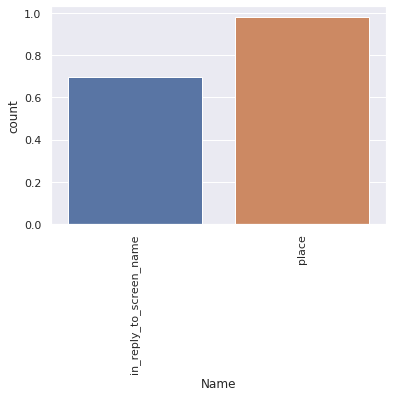

In [ ]:
plot_missing_values(df)

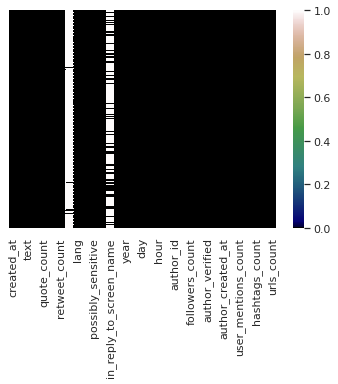

In [ ]:
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='gist_earth')

####Unique Values

In [ ]:
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

In [ ]:
unidf = return_unique_values(df[['author_id', 'lang','possibly_sensitive','is_quote_status',\
                                 'is_retweet','year','month','day','weekday','hour','author_loc',\
                                 'author_verified', 'in_reply_to_screen_name',]])
print(unidf)

                   Features  Uniques
0                 author_id      154
1                      lang       44
2        possibly_sensitive        1
3           is_quote_status        2
4                is_retweet        2
5                      year       15
6                     month       12
7                       day       31
8                   weekday        7
9                      hour       24
10               author_loc       92
11          author_verified        1
12  in_reply_to_screen_name     2350


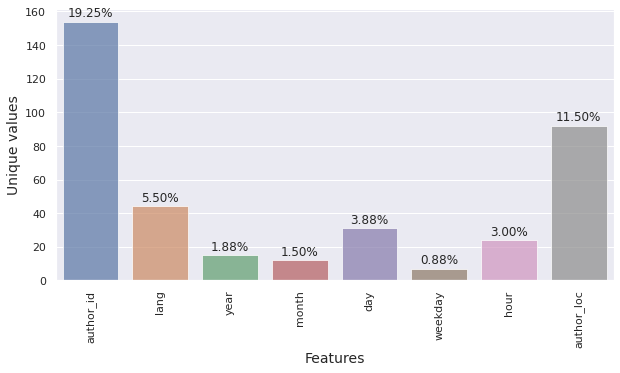

In [ ]:
unidf = return_unique_values(df[['author_id', 'lang','year','month','day','weekday','hour','author_loc']])
f, ax = plt.subplots(1,1, figsize=(10,5))

sns.barplot(x=unidf['Features'], y=unidf['Uniques'], alpha=0.7)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}%'.format(height/float(len(unidf))), ha="center")
plt.ylabel('Unique values', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.xticks(rotation=90)
plt.show()

Distribution of like counts

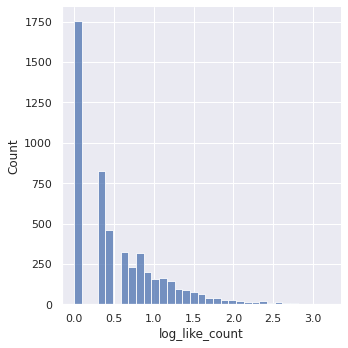

In [ ]:
sns.displot(df.log_like_count)

- Location data is mostly not available; cannot use it as a feature
- There are 154 unique authors in the dataset; including author IDs in the model input can help inform predictions as some authors may be more influencial and receive more likes
- The like count distribution is skewed; most of the tweets receive 0 likes; very few tweets receive >100 likes

#### User Analysis




/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


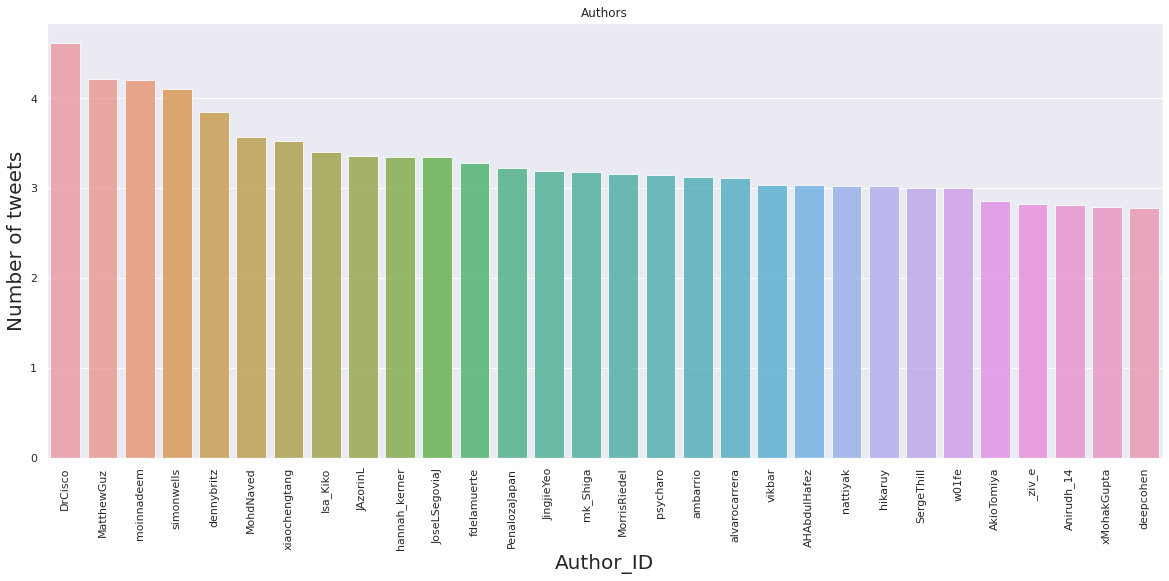

In [ ]:
author_count = df.groupby(['author_id']).first()['total_tweets_by_author_count'].sort_values(ascending=False)
len(df['author_id'].unique()), df['author_id'].unique()
plt.figure(figsize=(20,8))
sns.barplot(author_count.index[:30], np.log10(author_count.values[:30]), alpha=0.8)
plt.title('Authors')
plt.ylabel('Number of tweets', fontsize=20)
plt.xlabel('Author_ID', fontsize=20)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26087 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23665 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127470 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128747 missing from current font.
  font.s

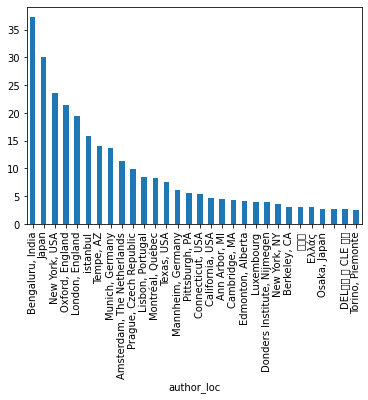

In [ ]:
#group data by author and display mean like count
df.groupby('author_loc')['like_count'].mean().sort_values(ascending=False)[:30].plot.bar()

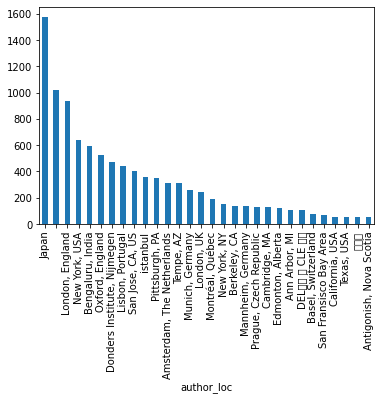

In [ ]:
#group data by author and display mean like count
df.groupby('author_loc')['like_count'].max().sort_values(ascending=False)[:30].plot.bar()

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20185 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20185 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 21488 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text

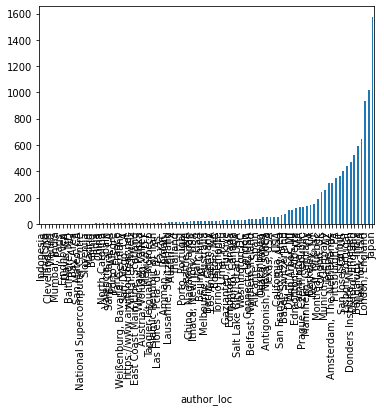

In [ ]:
#group data by author and display mean like count
df.groupby('author_loc')['like_count'].max().sort_values(ascending=True).plot.bar()

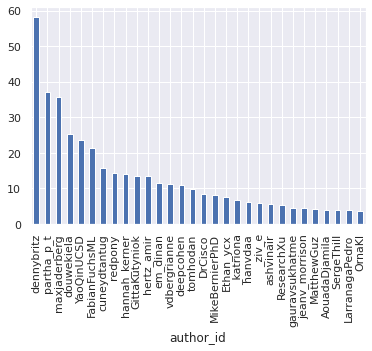

In [ ]:
#group data by author and display mean like count
df.groupby('author_id')['like_count'].mean().sort_values(ascending=False)[:30].plot.bar()

In [16]:
df.groupby('author_id')['like_count'].mean().sort_values(ascending=True)[:10]

author_id
antonio_star93     0.0
ParagNamjoshi      0.0
ShivajiraoJadha    0.0
SuatGumussoy       0.0
SuddenHonG         0.0
WillGrayRoncal     0.0
YonghaoXu1         0.0
chenghaoliu1989    0.0
MJamshidinia       0.0
eliaszwang         0.0
Name: like_count, dtype: float64

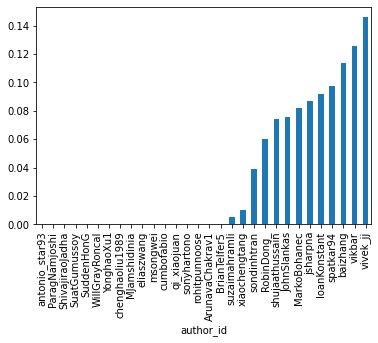

In [13]:
#group data by author and display mean like count
df.groupby('author_id')['like_count'].mean().sort_values(ascending=True)[:30].plot.bar()

In [17]:
df.groupby('author_id')['like_count'].max().sort_values(ascending=True)[:10]

author_id
antonio_star93     0
ShivajiraoJadha    0
SuatGumussoy       0
MJamshidinia       0
SuddenHonG         0
WillGrayRoncal     0
YonghaoXu1         0
chenghaoliu1989    0
cumbofabio         0
eliaszwang         0
Name: like_count, dtype: int64

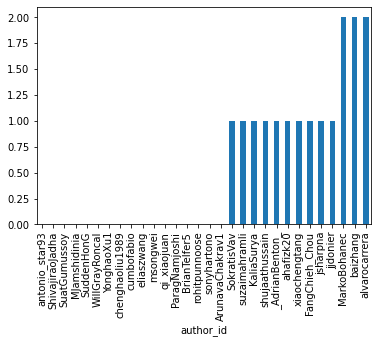

In [14]:
#group data by author and display mean like count
df.groupby('author_id')['like_count'].max().sort_values(ascending=True)[:30].plot.bar()

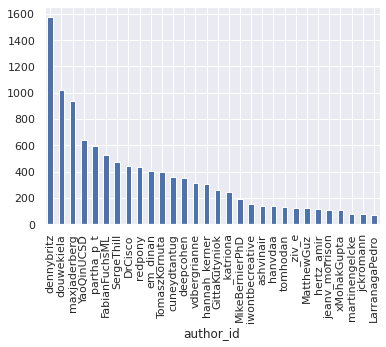

In [ ]:
#group data by author and display max like count
df.groupby('author_id')['like_count'].max().sort_values(ascending=False)[:30].plot.bar()

In [ ]:
author_df = df.groupby(['author_id']).first()['total_tweets_by_author_count'].reset_index(name='total_tweets')
d = {'sum': 'total_likes', 'mean' : 'avg_likes', 'max': 'max_likes', 'median': 'median_likes'}
author_df = pd.merge(author_df, df.groupby(['author_id']).agg({'like_count': ['mean', 'sum', 'max', 'median']}).rename(columns=d), on='author_id')
author_df.columns = author_df.columns.map(lambda t: t[1] if isinstance(t, tuple) else t)

<ipython-input-108-5d84df5a46d3>:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  author_df = pd.merge(author_df, df.groupby(['author_id']).agg({'like_count': ['mean', 'sum', 'max', 'median']}).rename(columns=d), on='author_id')


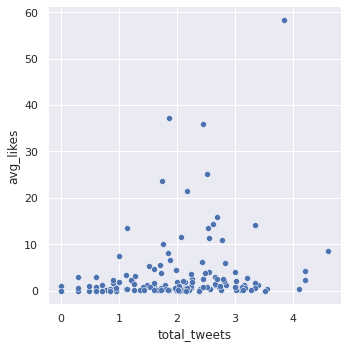

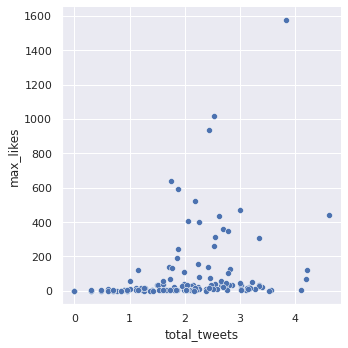

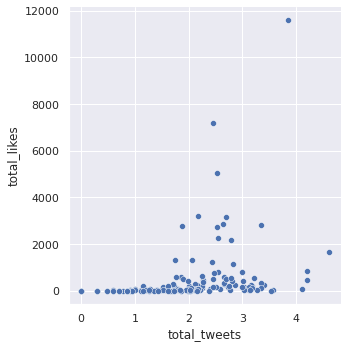

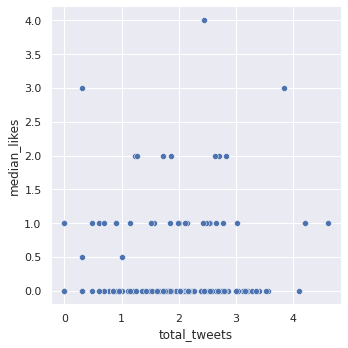

In [ ]:
author_df['total_tweets'] = author_df['total_tweets'].apply(lambda x: np.log10(x))
sns.relplot(data=author_df, x="total_tweets", y="avg_likes")
sns.relplot(data=author_df, x="total_tweets", y="max_likes")
sns.relplot(data=author_df, x="total_tweets", y="total_likes")
sns.relplot(data=author_df, x="total_tweets", y="median_likes")

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


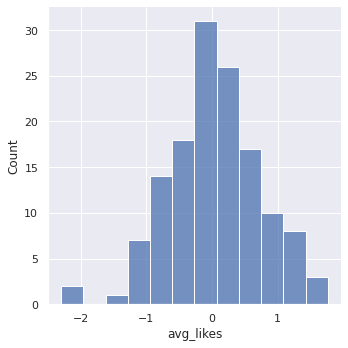

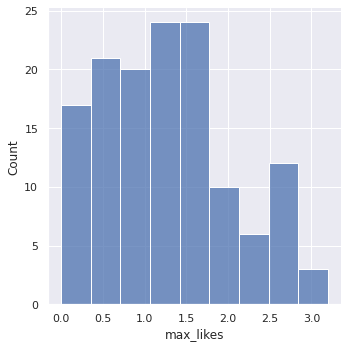

In [ ]:
sns.displot(np.log10(author_df['avg_likes']))
sns.displot(np.log10(author_df['max_likes']))

- Out of 141 total users, only 8 users contribute more than 5% of total tweets
- Only few influential users have large number of likes 
- Only few users tweet a lot
- There seems to be no correlation between number of tweets and number of likes one gets
- Need to construct a popularity metric of a user to inform the probability of getting more likes; this may depend on:
    - avg number of likes per tweet for the user - higher the better
    - max like count of the user - higher the better
    - more total tweets may increase the probability of getting likes but not so much
    - tweet topics - popular tweet topics get higher likes

    The above popularity metric will not be included as a feature, but for importance sampling - giving more weightage to influencial users

#### Language Analysis

In [ ]:
lang_df = df.groupby(['lang']).size().reset_index(name='total_tweets')
d = {'sum': 'total_likes', 'mean' : 'avg_likes', 'max': 'max_likes', 'median': 'median_likes'}
lang_df = pd.merge(lang_df, df.groupby(['lang']).agg({'like_count': ['mean', 'sum', 'max', 'median']}).rename(columns=d), on='lang')
lang_df.columns = lang_df.columns.map(lambda t: t[1] if isinstance(t, tuple) else t)

<ipython-input-111-e6dda8031d88>:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  lang_df = pd.merge(lang_df, df.groupby(['lang']).agg({'like_count': ['mean', 'sum', 'max', 'median']}).rename(columns=d), on='lang')


In [ ]:
lang_df.head()

,lang,total_tweets,avg_likes,total_likes,max_likes,median_likes
0,Arabic,412,0.500000,206,10,0.0
1,Basque,6,0.833333,5,2,0.5
2,Bulgarian,1,0.000000,0,0,0.0
3,Catalan,20,0.550000,11,4,0.0
4,Chinese,29,0.206897,6,6,0.0


Number of tweets per language

44 ['English' 'German' 'und' 'zxx' 'in' 'Portuguese' 'French' 'qme' 'Spanish'
 'Swedish' 'art' 'Tagalog' 'qam' 'Basque' 'Danish' 'Polish' 'qht'
 'Marathi' 'Arabic' 'qst' 'Estonian' 'Welsh' 'Haitian' 'Turkish' 'Dutch'
 'Finnish' 'Persian' 'Slovenian' 'Czech' 'Italian' 'Catalan' 'Russian'
 'Bulgarian' 'Japanese' 'Romanian' 'Korean' 'Chinese' 'Norwegian'
 'Modern Greek (1453-)' 'Hindi' 'iw' 'Urdu' 'Hungarian' 'Icelandic']


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


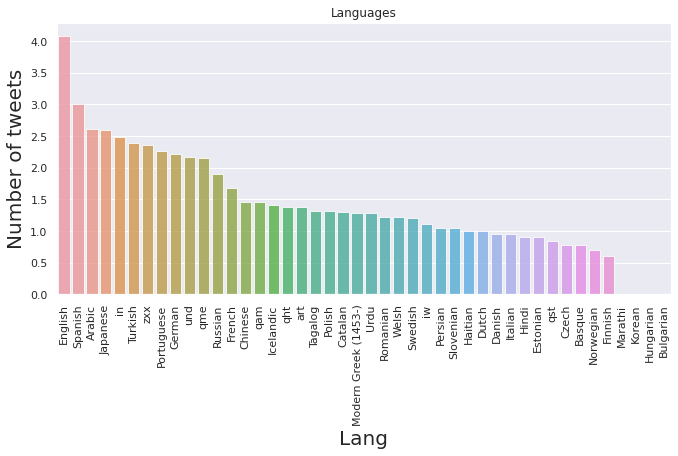

In [ ]:
lang_count = df['lang'].value_counts().sort_values(ascending=False)
print(len(df['lang'].unique()), df['lang'].unique())
plt.figure(figsize=(11,5))
sns.barplot(lang_count.index, np.log10(lang_count.values), alpha=0.8)
plt.title('Languages')
plt.ylabel('Number of tweets', fontsize=20)
plt.xlabel('Lang', fontsize=20)
plt.xticks(rotation=90)
plt.show()

In [ ]:
pop_df = df[df['like_count']>=100]
unpop_df = df[df['like_count']<100]

In [ ]:
pop_df['lang'].value_counts().sort_values(ascending=False)

English       122
Turkish         7
Portuguese      2
Name: lang, dtype: int64

In [ ]:
unpop_df['lang'].value_counts().sort_values(ascending=False)

English                 12125
Spanish                  1023
Arabic                    412
Japanese                  391
in                        306
Turkish                   236
zxx                       230
Portuguese                182
German                    167
und                       149
qme                       141
Russian                    81
French                     48
Chinese                    29
qam                        29
Icelandic                  26
qht                        24
art                        24
Tagalog                    21
Polish                     21
Catalan                    20
Modern Greek (1453-)       19
Urdu                       19
Romanian                   17
Welsh                      17
Swedish                    16
iw                         13
Persian                    11
Slovenian                  11
Haitian                    10
Dutch                      10
Danish                      9
Italian                     9
Hindi     

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


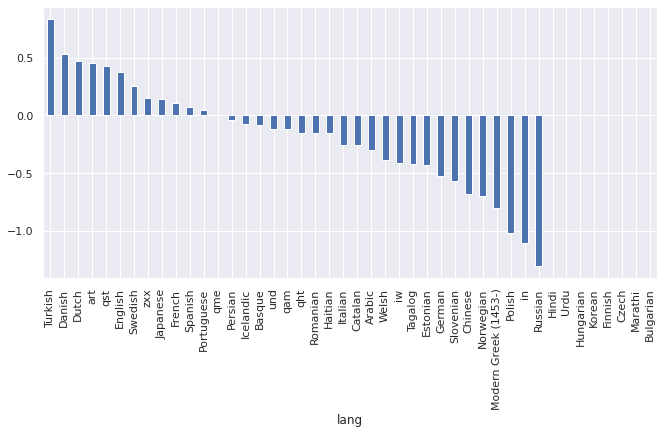

In [ ]:
plt.figure(figsize=(11,5))
np.log10(unpop_df.groupby('lang')['like_count'].mean().sort_values(ascending=False)).plot.bar()

Num likes per language

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


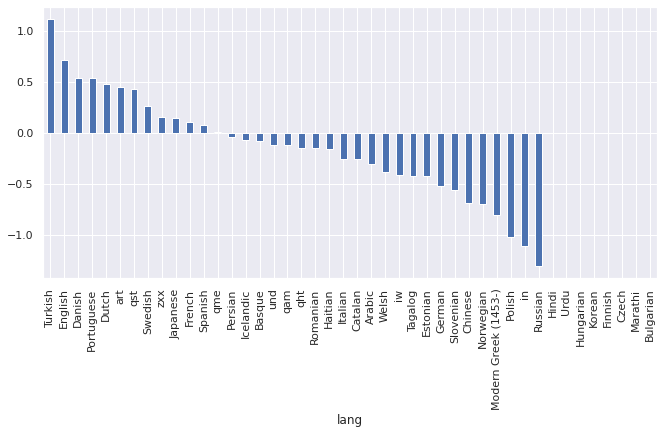

In [ ]:
plt.figure(figsize=(11,5))
np.log10(df.groupby('lang')['like_count'].mean().sort_values(ascending=False)).plot.bar()

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


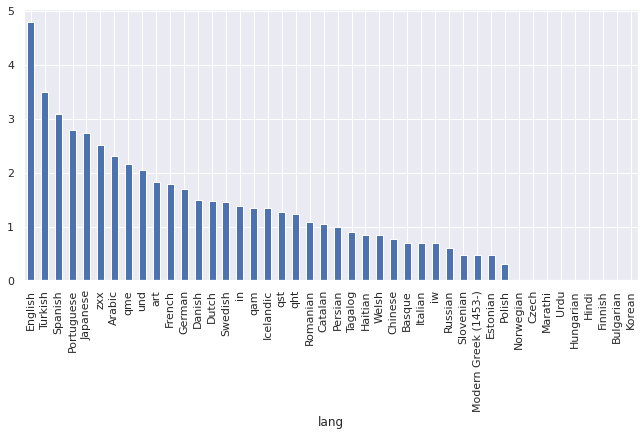

In [ ]:
plt.figure(figsize=(11,5))
np.log10(df.groupby('lang')['like_count'].sum().sort_values(ascending=False)).plot.bar()

Likes per tweet by language

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


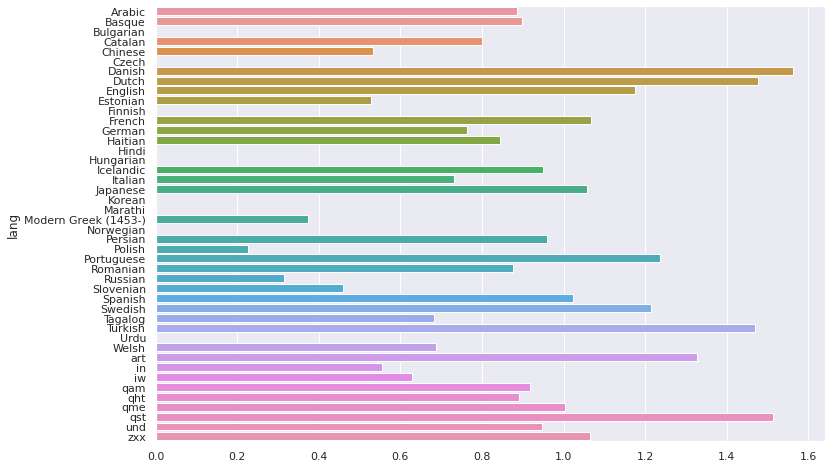

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(np.log10(lang_df['total_likes'])/np.log10(lang_df['total_tweets']), lang_df['lang'])

Some language tags do not make sense

In [ ]:
idx = list(df.index[df['lang']=='qme'])
df.loc[df['lang']=='qme']['text'].head()

308    @alex_peys https://t.co/NMJX36DTlk https://t.c...
349    RT @gtbnetwork: @Sousa8Carmo @gaydedireitaPB h...
585    RT @rodrigodsdev: #Elaleph #newcreativity @the...
654    @alexmarket @AlxRubio @jOkAmE https://t.co/spH...
655                    @the_i2ds https://t.co/TQUBtHgDxn
Name: text, dtype: object

- Most of the tweets are in English language; Spanish, Japanese, Chinese, Portugese also constitute majority tweets
- Average like count for Portugese, Turkish, English and 'art' (un-idetified language) are the highest while Russian, Chinese, Czech, 'in' have low average like counts
- There are some un-identified languages in the dataset like 'qme', 'in' etc. which do not make any semantic sense as texts for such tweets usually contains only user mentions or URLs

#### Time Analysis

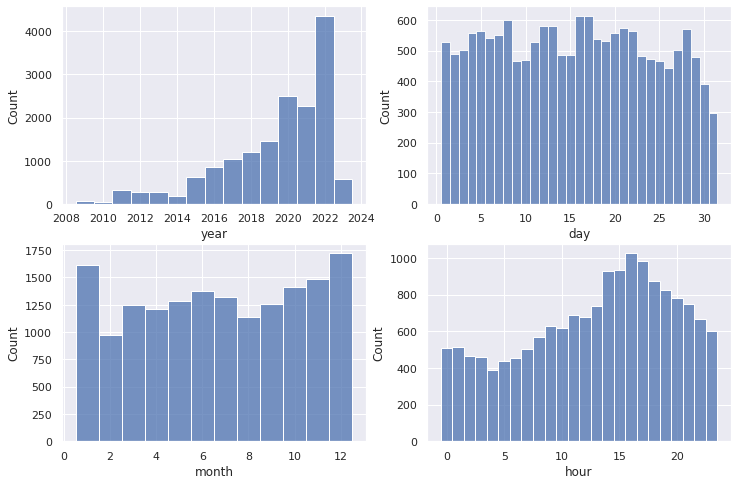

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df, x = 'year', discrete = True, ax = axs[0,0]);
sns.histplot(df, x = 'day', discrete = True, ax = axs[0,1]);
sns.histplot(df, x = 'month', discrete = True, ax = axs[1,0]);
sns.histplot(df, x = 'hour', discrete = True, ax = axs[1,1]);

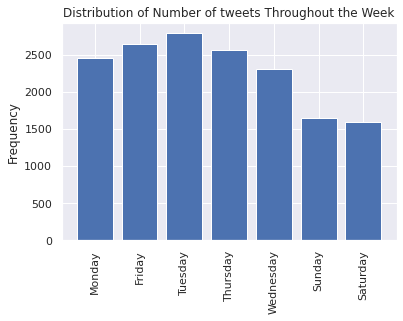

In [ ]:
from collections import Counter
plt.subplots(figsize=(6,4))
day_objects = [each.weekday() for each in df['created_at']]
x_pos = Counter(day_objects).keys()
height = Counter(day_objects).values()
days = ('Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday')
plt.bar(x_pos,height,align='center')
plt.xticks(list(x_pos), days, rotation=90) 
plt.ylabel("Frequency")
plt.title("Distribution of Number of tweets Throughout the Week")
plt.show()

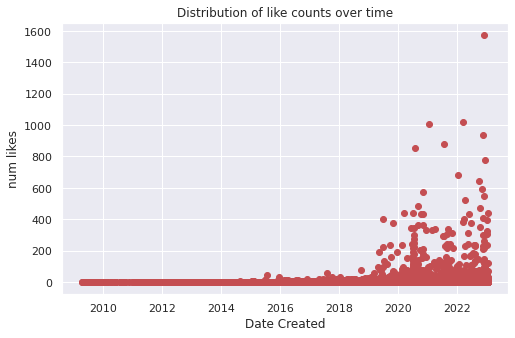

In [ ]:
plt.subplots(figsize=(8,5))
plt.plot_date(df['created_at'], df['like_count'], color='r')
plt.ylabel('num likes')
plt.xlabel('Date Created')
plt.title('Distribution of like counts over time')
plt.show()

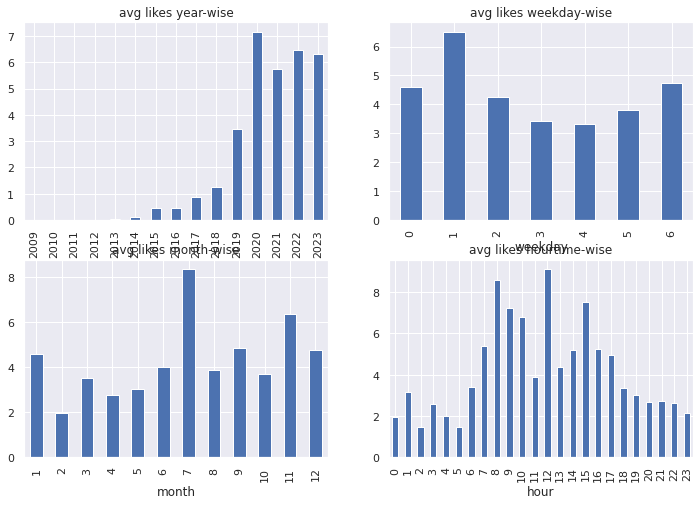

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# df.groupby(df["year"])['like_count'].sum().plot(kind="bar", title='total number of likes year-wise', ax=axs[0,0])
df.groupby(df["year"])['like_count'].mean().plot(kind="bar", title='avg likes year-wise', ax=axs[0,0])
df.groupby(df["weekday"])['like_count'].mean().plot(kind="bar", title='avg likes weekday-wise', ax=axs[0,1])
# df.groupby(df["month"])['like_count'].sum().plot(kind="bar", title='total number of likes month-wise', ax=axs[1,0])
df.groupby(df["month"])['like_count'].mean().plot(kind="bar", title='avg likes month-wise', ax=axs[1,0])
df.groupby(df["hour"])['like_count'].mean().plot(kind="bar", title='avg likes hourtime-wise', ax=axs[1,1])

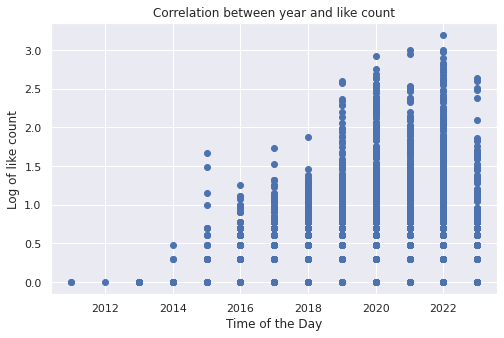

In [ ]:
plt.subplots(figsize=(8,5))
plt.scatter(df['year'], df['like_count'].apply(lambda x : np.log10(x)))
plt.title("Correlation between year and like count")
plt.xlabel('Time of the Day')
plt.ylabel('Log of like count')
plt.show()

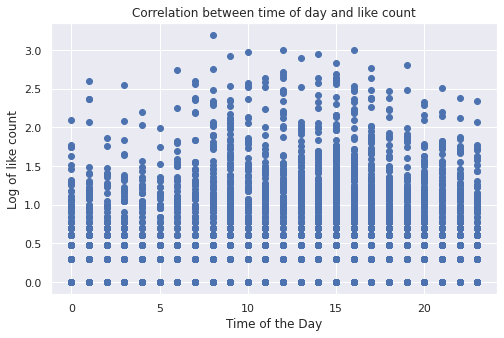

In [ ]:
plt.subplots(figsize=(8,5))
plt.scatter(df['hour'], df['like_count'].apply(lambda x : np.log10(x)))
plt.title("Correlation between time of day and like count")
plt.xlabel('Time of the Day')
plt.ylabel('Log of like count')
plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


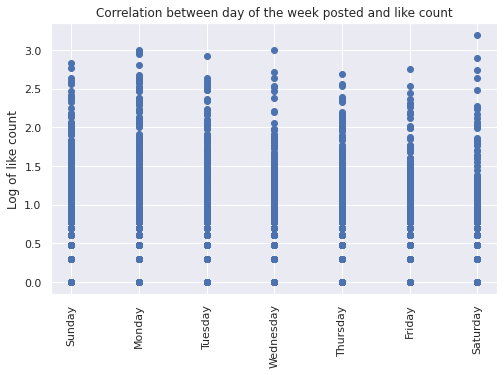

In [ ]:
plt.subplots(figsize=(8,5))
plt.scatter(df['weekday'], np.log10(df['like_count']))
x_pos_x=range(0,7)
plt.xticks(list(x_pos_x), ('Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'), rotation=90) 
plt.title("Correlation between day of the week posted and like count")
plt.ylabel('Log of like count')
plt.show()

- Almost all tweets before 2018 get very few likes; tweets and like counts in 2018-2022 period have better distribution for modelling
- Tweets posted in the morning before noon (9am-12pm) and around mid-night (12am-1am) seems to get more likes on average
- Tweets at the end and start of the year (Nov-Feb) get more avg likes; it may be the time when users post about their published papers and AI/ML concepts as some conferences happen during this time

#### Text Analysis

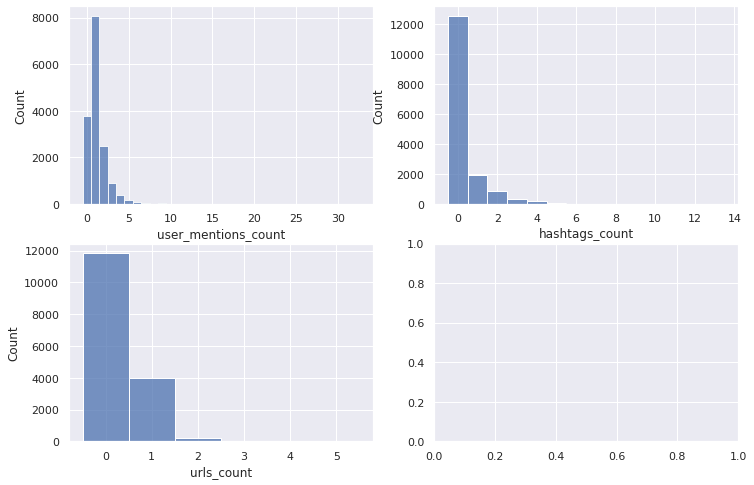

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df, x = 'user_mentions_count', discrete = True, ax = axs[0,0]);
sns.histplot(df, x = 'hashtags_count', discrete = True, ax = axs[0,1]);
sns.histplot(df, x = 'urls_count', discrete = True, ax = axs[1,0]);
# sns.histplot(df, x = 'num_annotations', discrete = True, ax = axs[1,1]);

[Text(0, 0.5, 'like_count'), Text(0.5, 0, 'urls_count')]

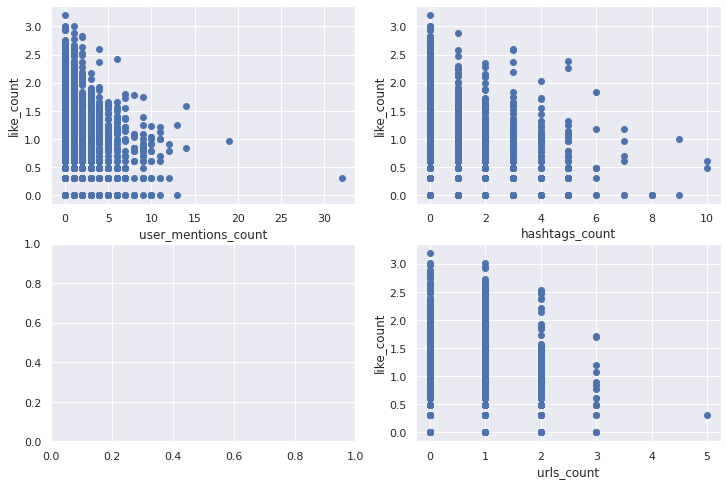

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
y = df['log_like_count']
axs[0,0].scatter(df['user_mentions_count'], y)
axs[0,0].set(xlabel='user_mentions_count', ylabel = 'like_count')
axs[0,1].scatter(df['hashtags_count'], y)
axs[0,1].set(xlabel='hashtags_count', ylabel = 'like_count')
axs[1,1].scatter(df['urls_count'], y)
axs[1,1].set(xlabel='urls_count', ylabel = 'like_count')

- Tweets with more number of user mentions or hashtags usually get less likes
- There seems to be no correlation of number of user mentions, URls, hashtags or annotations with high like counts

## EDA findings summarised

- Location data is mostly not available; cannot use it as a feature
- There are 141 unique authors in the dataset; including author IDs in the model input can help inform predictions as some authors may be more influencial and receive more likes
- The like count distribution is skewed; most of the tweets receive 0 likes; very few tweets receive >100 likes

- Out of 141 total users, only 8 users contribute more than 5% of total tweets
- Only few influential users have large number of likes 
- Only few users tweet a lot
- There seems to be no correlation between number of tweets and number of likes one gets
- Can construct a popularity metric of a user to inform the probability of getting more likes (this popularity metric will not be included as a feature, but can be used for importance sampling - giving more weightage to influencial users); this may depend on:
    - avg number of likes per tweet for the user - higher the better
    - max like count of the user - higher the better
    - more total tweets may increase the probability of getting likes but not so much
    - tweet topics - popular tweet topics get higher likes

- Most of the tweets are in English language; Spanish, Japanese, Chinese, Portuguese also constitute majority tweets
- Average like count for Portuguese, Turkish, English and 'art' (un-idetified language) are the highest while Russian, Chinese, Czech, 'in' have low average like counts
- There are some un-identified languages in the dataset like 'qme', 'in' etc. which do not make any semantic sense as texts for such tweets usually contains only user mentions or URLs


- Almost all tweets before 2018 get very few likes; tweets and like counts in 2018-2022 period have better distribution for modelling
- Tweets posted in the morning before noon (9am-12pm) and around mid-night (12am-1am) seems to get more likes on average
- Tweets at the end and start of the year (Nov-Feb) get more avg likes; it may be the time when users post about their published papers and AI/ML concepts as some conferences happen during this time

- Tweets with more number of user mentions or hashtags usually get less likes
- There seems to be no correlation of number of user mentions, URls, hashtags or annotations with high like counts
- Like counts seems to be correlated with quote count, reply count and retweet count


- All re-tweets have 0 likes

## Feature Correlation

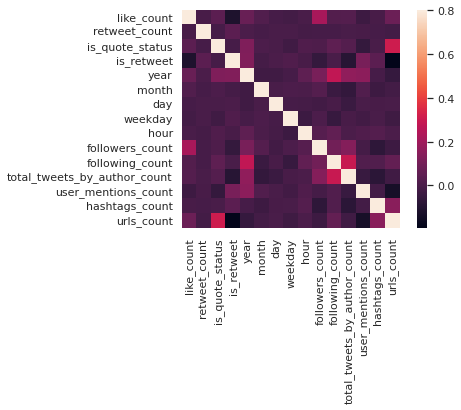

In [ ]:
corrmat = df.drop(columns=['quote_count', 'reply_count', 'possibly_sensitive', 'author_verified', 'log_like_count']).corr()
# [2:] 
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
df_corr = df.corr()['like_count']
top_features = df_corr.sort_values(ascending=False)
top_features

like_count                      1.000000
log_like_count                  0.574777
followers_count                 0.219471
urls_count                      0.082099
year                            0.071081
is_quote_status                 0.042488
total_tweets_by_author_count    0.026494
following_count                 0.023791
month                           0.019536
hour                           -0.000923
retweet_count                  -0.004454
hashtags_count                 -0.004811
day                            -0.007942
weekday                        -0.015019
user_mentions_count            -0.031980
is_retweet                     -0.115025
quote_count                          NaN
reply_count                          NaN
possibly_sensitive                   NaN
author_verified                      NaN
Name: like_count, dtype: float64

In [ ]:
df.corr()['log_like_count'].sort_values(ascending=False)

log_like_count                  1.000000
like_count                      0.574777
retweet_count                   0.491022
followers_count                 0.243216
urls_count                      0.219589
is_quote_status                 0.187211
year                            0.148984
hashtags_count                  0.060403
following_count                 0.045507
month                           0.034004
hour                            0.000710
day                            -0.002302
total_tweets_by_author_count   -0.011375
user_mentions_count            -0.016870
weekday                        -0.049147
quote_count                          NaN
reply_count                          NaN
possibly_sensitive                   NaN
is_retweet                           NaN
author_verified                      NaN
Name: log_like_count, dtype: float64

## Pre-process dataset
- Split train, validation, test
- Pre-process text
    - tokenisation [BERTweet](https://aclanthology.org/2020.emnlp-demos.2.pdf)
- Pre-trained Models
    - [XLM-T](https://aclanthology.org/2022.lrec-1.27.pdf) - multilingual 
    - [BERTweet](https://aclanthology.org/2020.emnlp-demos.2.pdf) - monolingual English
